# 2. Entrenando Redes Neuronales en PyTorch

No importa lo grande, compleja y "estado del arte" que sea tu red neuronal: Si no ha entrenado, es bastante probable que se desempeñe pobremente en cualquier conjunto de datos.

_Gradient descent_ es un gran algoritmo para disminuir la función de pérdida o error a medida que nos adentramos en el entrenamiento. Recordemos que la manera en la que hacemos que una red neuronal aprenda (o, si al caso vamos, cualquier modelo de machin learning) es mediante la optimización (en este caso, minimización) del error entre las predicciones y los datos reales.

Entonces, para una red neuronal de una sola capa, implementar _gradient descent_ realmente no es tan complicado, pero cuando añadimos más y más capas, debemos recurrir a un método más sofisticado conocido como __backpropagation__.

Aunque _backpropagation_ está fuera del alcance de este notebook, [aquí hay un recurso](https://codesachin.wordpress.com/2015/12/06/backpropagation-for-dummies/) que me ayudó bastante a entender dicho concepto. 

## Autograd

Autograd es un módulo de PyTorch para calcular el gradiente de los tensores. 

Mantiene un registro de las operaciones ejecutadas sobre ellos.

Le podemos indicar a PyTorch que lleve control de los gradientes de varias maneras:
  - Al momento de crear un tensor: `my_tensor = torch.ones(10, requires_grad=True)`
  - In situ: `my_tensor.requires_grad_(True)`

## Preliminares

Con el fin de entender mejor cómo entrenar una red, necesitaremos importar un montón de librerías y paquetes.

Hagámoslo.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict

import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import utils

In [2]:
x = torch.randn(2, 2, requires_grad=True)
print(x)

tensor([[ 0.4312, -0.2288],
        [-0.8052, -0.2529]], requires_grad=True)


In [3]:
y = x ** 2
print(y)

tensor([[0.1860, 0.0524],
        [0.6483, 0.0640]], grad_fn=<PowBackward0>)


En la celda de abajo podemos ver la función de derivación (gradiente) que Autograd creó para la operación de potenciación al cuadrado que especificamos anteriormente.

In [4]:
# Shows the function generated by this variable
print(y.grad_fn)

Calculemos la media de este tensor y, seguidamente, computemos su gradiente con el método `backward()`.

In [5]:
z = y.mean()
print(z)

tensor(0.2376, grad_fn=<MeanBackward1>)


In [6]:
z.backward()
print(x.grad)
print(x / 2)

tensor([[ 0.2156, -0.1144],
        [-0.4026, -0.1264]])
tensor([[ 0.2156, -0.1144],
        [-0.4026, -0.1264]], grad_fn=<DivBackward0>)


Estos cálculos de gradientes son la clave para que las redes neuronales aprendan, dado que _backpropagation_ requiere que el error se propague de las últimas hacia las primeras capas del modelo.


## Obteniendo los Datos

Aquí descargaremos el conjunto de datos MNIST.

También definimos un par de transformaciones a llevar a cabo sobre las imágenes antes de pasárselas a la red. Particularmente, las convertiremos en tensores de PyTorch y después las normalizaremos.

In [7]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

## Arquitectura

Aquí es donde definimos la red neuronal como tal.

No activaremos las salidas de esta red. En cambio, produciremos _logits_ puros porque producir directamente los resultados de una función _softmax_, la cual genera una distribución de probabilidad sobre las etiquetas, conduce a problemas de inestabilidad numérica ya que los valores están demasiado cerca de 1 o 0.

In [8]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(OrderedDict([
            ('fully_connected_1', nn.Linear(input_size, hidden_sizes[0])),
            ('relu_1', nn.ReLU()),
            ('fully_connected_2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
            ('relu_2', nn.ReLU()),
            ('logits', nn.Linear(hidden_sizes[1], output_size))
        ]))

## Entrenando las Red

Para entrenar la red necesitamos definir la función de pérdida (comúnmente referida como el _criterio_ o, en inglés, _criterion_). 

Usaremos `nn.CrossEntropyLoss()` porque estamos implementando una salida _softmax_.

Para optimizar esta función de pérdida, nos apoyaremos en SGD. Fíjate en que debemos pasar los parámetros que queremos optimizar, los cuales, en el 99% de los casos, serán los de la red que deseamos entrenar.

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Abajo se encuentra el código correspondiente a un solo paso del entrenamiento.

Primero, ejecutamos un pase hacia adelante llamadno al método `forward()` sobre el modelo.

Después, computamos el error usando nuestro `criterion`. Para ello, le pasamos las etiquetas reales y las salidas de la red.

Luego, propagamos hacia atrás el error usando el método `backward()`.

Finalmente, actualizamos los parámetros llamando al método `step()` sobre el optimizador.

In [10]:
print(f'Initial weights - {model.fully_connected_1.weight}')

images, labels = next(iter(train_loader))
images.resize_(64, 784)

# Clear the gradients. We need to do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward, then update
output = model.forward(images)
loss = criterion(output, labels)
loss.backward()
print(f'Gradient - {model.fully_connected_1.weight.grad}')
optimizer.step()

Initial weights - Parameter containing:
tensor([[ 0.0198, -0.0353,  0.0005,  ...,  0.0129, -0.0194, -0.0167],
        [-0.0172, -0.0027, -0.0169,  ...,  0.0315, -0.0208, -0.0124],
        [-0.0347,  0.0233, -0.0223,  ...,  0.0299,  0.0345, -0.0140],
        ...,
        [-0.0257,  0.0205,  0.0093,  ..., -0.0169,  0.0268,  0.0280],
        [-0.0260,  0.0152,  0.0153,  ..., -0.0214,  0.0320, -0.0011],
        [-0.0149, -0.0354, -0.0199,  ...,  0.0220, -0.0044, -0.0019]],
       requires_grad=True)
Gradient - tensor([[-0.0012, -0.0012, -0.0012,  ..., -0.0012, -0.0012, -0.0012],
        [ 0.0070,  0.0070,  0.0070,  ...,  0.0070,  0.0070,  0.0070],
        [ 0.0019,  0.0019,  0.0019,  ...,  0.0019,  0.0019,  0.0019],
        ...,
        [ 0.0004,  0.0004,  0.0004,  ...,  0.0004,  0.0004,  0.0004],
        [ 0.0013,  0.0013,  0.0013,  ...,  0.0013,  0.0013,  0.0013],
        [-0.0019, -0.0019, -0.0019,  ..., -0.0019, -0.0019, -0.0019]])


In [11]:
print(f'Updated weights - {model.fully_connected_1.weight}')

Updated weights - Parameter containing:
tensor([[ 0.0198, -0.0352,  0.0005,  ...,  0.0129, -0.0194, -0.0167],
        [-0.0173, -0.0028, -0.0170,  ...,  0.0314, -0.0209, -0.0124],
        [-0.0348,  0.0233, -0.0224,  ...,  0.0299,  0.0345, -0.0140],
        ...,
        [-0.0257,  0.0205,  0.0093,  ..., -0.0170,  0.0268,  0.0280],
        [-0.0260,  0.0152,  0.0153,  ..., -0.0214,  0.0320, -0.0011],
        [-0.0149, -0.0354, -0.0199,  ...,  0.0220, -0.0044, -0.0019]],
       requires_grad=True)


Para entrenar de verdad, sólo debemos repetir el paso anterior para cada lote de datos, durante cada epoch.

In [12]:
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [13]:
epochs = 3
print_every = 40
steps = 0

for epoch in range(epochs):
    running_loss = 0
    for images, labels in iter(train_loader):
        steps += 1
        
        images.resize_(images.size()[0], 784)  # Flatten
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            print(f'Epoch: {epoch + 1}/{epochs}...\nLoss: {running_loss/print_every}')
            
            running_loss = 0

Epoch: 1/3...
Loss: 2.283420580625534
Epoch: 1/3...
Loss: 2.2530458986759188
Epoch: 1/3...
Loss: 2.226108205318451
Epoch: 1/3...
Loss: 2.2017243444919585
Epoch: 1/3...
Loss: 2.1648906111717223
Epoch: 1/3...
Loss: 2.138554239273071
Epoch: 1/3...
Loss: 2.1004577934741975
Epoch: 1/3...
Loss: 2.0624050438404082
Epoch: 1/3...
Loss: 2.015454387664795
Epoch: 1/3...
Loss: 1.980192482471466
Epoch: 1/3...
Loss: 1.9096643090248109
Epoch: 1/3...
Loss: 1.8619372367858886
Epoch: 1/3...
Loss: 1.8116183131933212
Epoch: 1/3...
Loss: 1.7427437245845794
Epoch: 1/3...
Loss: 1.657833382487297
Epoch: 1/3...
Loss: 1.6017267167568208
Epoch: 1/3...
Loss: 1.519508996605873
Epoch: 1/3...
Loss: 1.4497936874628068
Epoch: 1/3...
Loss: 1.380399578809738
Epoch: 1/3...
Loss: 1.317969125509262
Epoch: 1/3...
Loss: 1.2599974572658539
Epoch: 1/3...
Loss: 1.1765944331884384
Epoch: 1/3...
Loss: 1.1281732365489006
Epoch: 2/3...
Loss: 0.6062858313322067
Epoch: 2/3...
Loss: 1.0808843582868577
Epoch: 2/3...
Loss: 0.980318254232

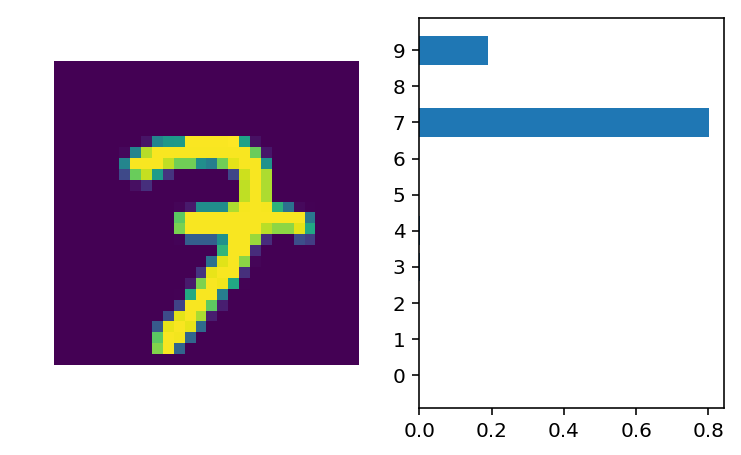

In [14]:
images, labels = next(iter(train_loader))

image = images[2].view(1, 784)

# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(image)
    
predictions = F.softmax(logits, dim=1)
utils.view_classify(image.view(1, 28, 28), predictions)

¡Nuestra red es mucho más inteligente que la que usamos en el notebook anterior!